In [ ]:
import pandas as pd

file_path = '/content/submission_df.csv'
df = pd.read_csv(file_path)
df.head()

,WTeamID,LTeamID,gender,Wins_sum_w_x,GamesPlayed_sum_w_x,AvgScore_mean_w_x,AvgScore_std_w_x,AvgDayNum_mean_w_x,WinRatio_mean_w_x,WinRatio_std_w_x,...,AvgMargin_mean_l_y,AvgMargin_std_l_y,Possession_Control_mean_l_y,Possession_Control_std_l_y,Shooting_Efficiency_mean_l_y,Shooting_Efficiency_std_l_y,Assist_Ratio_mean_l_y,Assist_Ratio_std_l_y,Balanced_Score_mean_l_y,Balanced_Score_std_l_y
0,1101,1102,m,2351,4248,70.72,3.05,74.51,0.55,0.18,...,-0.31,6.45,24.14,9.10,0.57,0.16,0.40,0.15,9.97,3.68
1,1101,1103,m,2351,4248,70.72,3.05,74.51,0.55,0.18,...,5.13,3.50,28.44,8.54,0.55,0.13,0.35,0.12,11.67,3.44
2,1101,1104,m,2351,4248,70.72,3.05,74.51,0.55,0.18,...,5.21,3.89,31.41,9.30,0.54,0.13,0.32,0.12,12.85,3.75
3,1101,1105,m,2351,4248,70.72,3.05,74.51,0.55,0.18,...,-5.08,3.87,30.98,7.95,0.52,0.09,0.32,0.11,12.66,3.19
4,1101,1106,m,2351,4248,70.72,3.05,74.51,0.55,0.18,...,-2.56,4.73,28.89,10.26,0.50,0.14,0.30,0.13,11.82,4.14


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131407 entries, 0 to 131406
Data columns (total 71 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   WTeamID                       131407 non-null  int64  
 1   LTeamID                       131407 non-null  int64  
 2   gender                        131407 non-null  object 
 3   Wins_sum_w_x                  131407 non-null  int64  
 4   GamesPlayed_sum_w_x           131407 non-null  int64  
 5   AvgScore_mean_w_x             131407 non-null  float64
 6   AvgScore_std_w_x              131407 non-null  float64
 7   AvgDayNum_mean_w_x            131407 non-null  float64
 8   WinRatio_mean_w_x             131407 non-null  float64
 9   WinRatio_std_w_x              131407 non-null  float64
 10  AvgMargin_mean_w_x            131407 non-null  float64
 11  AvgMargin_std_w_x             131407 non-null  float64
 12  Possession_Control_mean_w_x   131407 non-nul

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

X = df.copy()

le_gender = LabelEncoder()
X['gender'] = le_gender.fit_transform(X['gender'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = np.ones(len(X_scaled))  
X_flipped = df.copy()
X_flipped['gender'] = le_gender.transform(X_flipped['gender'])

for col in df.columns:
    if "_w" in col:
        match = col.replace("_w", "")
        if f"{match}_l" in df.columns:
            X_flipped[col] = df[f"{match}_l"]
    elif "_l" in col:
        match = col.replace("_l", "")
        if f"{match}_w" in df.columns:
            X_flipped[col] = df[f"{match}_w"]

X_flipped_scaled = scaler.transform(X_flipped)
y_flipped = np.zeros(len(X_flipped_scaled))

X_final = np.vstack([X_scaled, X_flipped_scaled])
y_final = np.hstack([y, y_flipped])

shuffle_idx = np.random.permutation(len(X_final))
X_final, y_final = X_final[shuffle_idx], y_final[shuffle_idx]

sequence_length = 5
num_features = X_final.shape[1]

cut_len = (X_final.shape[0] // sequence_length) * sequence_length
X_seq = X_final[:cut_len].reshape(-1, sequence_length, num_features)
y_seq = y_final[:cut_len].reshape(-1, sequence_length)[:, -1]  
X_seq.shape, y_seq.shape

((52562, 5, 71), (52562,))

### Forward propagation

In [ ]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dsigmoid(x):
    s = sigmoid(x)
    return s * (1 - s)

def dtanh(x):
    return 1 - np.tanh(x) ** 2

def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-8
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def dbce(y_true, y_pred):
    epsilon = 1e-8
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return (y_pred - y_true) / (y_pred * (1 - y_pred) * len(y_true))

class LSTM:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
    
        self.Wf = np.random.randn(hidden_size, input_size + hidden_size) * 0.1
        self.bf = np.zeros((hidden_size, 1))

        self.Wi = np.random.randn(hidden_size, input_size + hidden_size) * 0.1
        self.bi = np.zeros((hidden_size, 1))

        self.Wc = np.random.randn(hidden_size, input_size + hidden_size) * 0.1
        self.bc = np.zeros((hidden_size, 1))

        self.Wo = np.random.randn(hidden_size, input_size + hidden_size) * 0.1
        self.bo = np.zeros((hidden_size, 1))

        self.Wy = np.random.randn(output_size, hidden_size) * 0.1
        self.by = np.zeros((output_size, 1))

    def forward(self, x_seq):
        h_prev = np.zeros((self.hidden_size, 1))
        c_prev = np.zeros((self.hidden_size, 1))

        self.cache = []

        for t in range(x_seq.shape[0]):
            x_t = x_seq[t].reshape(-1, 1)
            concat = np.vstack((h_prev, x_t))

            ft = sigmoid(self.Wf @ concat + self.bf)
            it = sigmoid(self.Wi @ concat + self.bi)
            c_tilde = np.tanh(self.Wc @ concat + self.bc)
            ct = ft * c_prev + it * c_tilde
            ot = sigmoid(self.Wo @ concat + self.bo)
            ht = ot * np.tanh(ct)

            self.cache.append((ht, ct, ft, it, c_tilde, ot, concat, h_prev, c_prev))

            h_prev = ht
            c_prev = ct

        y_hat = sigmoid(self.Wy @ h_prev + self.by)
        return y_hat, h_prev

sample_batch = X_seq[:1][0] 
sample_label = y_seq[:1]

input_size = sample_batch.shape[1]
hidden_size = 32
output_size = 1

lstm_model = LSTM(input_size, hidden_size, output_size)
y_pred, _ = lstm_model.forward(sample_batch)

y_pred

array([[0.50600959]])

### SGD-based training

In [ ]:
class LSTMWithSGD(LSTM):
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        super().__init__(input_size, hidden_size, output_size)
        self.lr = learning_rate

    def backward(self, x_seq, y_true, y_pred):        
        dy = y_pred - y_true        
        dWy = dy @ self.cache[-1][0].T
        dby = dy
       
        dWf = np.zeros_like(self.Wf)
        dWi = np.zeros_like(self.Wi)
        dWc = np.zeros_like(self.Wc)
        dWo = np.zeros_like(self.Wo)
        dbf = np.zeros_like(self.bf)
        dbi = np.zeros_like(self.bi)
        dbc = np.zeros_like(self.bc)
        dbo = np.zeros_like(self.bo)

        dh_next = np.zeros((self.hidden_size, 1))
        dc_next = np.zeros((self.hidden_size, 1))

        for t in reversed(range(len(self.cache))):
            ht, ct, ft, it, c_tilde, ot, concat, h_prev, c_prev = self.cache[t]

            dht = self.Wy.T @ dy + dh_next
            dot = dht * np.tanh(ct)
            dct = dht * ot * dtanh(np.tanh(ct)) + dc_next
            dft = dct * c_prev
            dit = dct * c_tilde
            dc_tilde = dct * it

            dft_input = dft * dsigmoid(self.Wf @ concat + self.bf)
            dit_input = dit * dsigmoid(self.Wi @ concat + self.bi)
            dc_tilde_input = dc_tilde * dtanh(self.Wc @ concat + self.bc)
            dot_input = dot * dsigmoid(self.Wo @ concat + self.bo)

            dWf += dft_input @ concat.T
            dWi += dit_input @ concat.T
            dWc += dc_tilde_input @ concat.T
            dWo += dot_input @ concat.T

            dbf += dft_input
            dbi += dit_input
            dbc += dc_tilde_input
            dbo += dot_input

            dconcat = (
                self.Wf.T @ dft_input +
                self.Wi.T @ dit_input +
                self.Wc.T @ dc_tilde_input +
                self.Wo.T @ dot_input
            )
            dh_next = dconcat[:self.hidden_size, :]
            dc_next = dct * ft
        
        self.Wy -= self.lr * dWy
        self.by -= self.lr * dby

        self.Wf -= self.lr * dWf
        self.bf -= self.lr * dbf
        self.Wi -= self.lr * dWi
        self.bi -= self.lr * dbi
        self.Wc -= self.lr * dWc
        self.bc -= self.lr * dbc
        self.Wo -= self.lr * dWo
        self.bo -= self.lr * dbo

    def train(self, X, y, epochs=10):
        loss_log = []
        for epoch in range(epochs):
            total_loss = 0
            correct = 0
            for i in range(len(X)):
                x_seq = X[i]
                y_true = y[i]
                y_pred, _ = self.forward(x_seq)

                loss = binary_cross_entropy(np.array([y_true]), y_pred)
                total_loss += loss

                if (y_pred > 0.5 and y_true == 1) or (y_pred <= 0.5 and y_true == 0):
                    correct += 1

                self.backward(x_seq, y_true, y_pred)

            avg_loss = total_loss / len(X)
            accuracy = correct / len(X)
            loss_log.append((epoch + 1, avg_loss, accuracy))
            print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Accuracy: {accuracy*100:.2f}%")
        return loss_log

    def predict(self, X):
        predictions = []
        for x_seq in X:
            y_pred, _ = self.forward(x_seq)
            predictions.append(y_pred)
        return predictions

X_train_small = X_seq[:2000]
y_train_small = y_seq[:2000]

lstm_sgd = LSTMWithSGD(input_size=71, hidden_size=32, output_size=1, learning_rate=0.01)
sgd_training_log = lstm_sgd.train(X_train_small, y_train_small, epochs=10)


Epoch 1/10 | Loss: 0.6961 | Accuracy: 48.85%
Epoch 2/10 | Loss: 0.6940 | Accuracy: 51.05%
Epoch 3/10 | Loss: 0.6925 | Accuracy: 51.75%
Epoch 4/10 | Loss: 0.6909 | Accuracy: 52.15%
Epoch 5/10 | Loss: 0.6892 | Accuracy: 53.50%
Epoch 6/10 | Loss: 0.6867 | Accuracy: 54.80%
Epoch 7/10 | Loss: 0.6831 | Accuracy: 55.25%
Epoch 8/10 | Loss: 0.6780 | Accuracy: 56.95%
Epoch 9/10 | Loss: 0.6714 | Accuracy: 58.35%
Epoch 10/10 | Loss: 0.6645 | Accuracy: 59.10%


In [ ]:
class LSTMWithAdam(LSTM):
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(input_size, hidden_size, output_size)
        self.lr = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 1  
        
        self.m = {}
        self.v = {}
        for param in ['Wf', 'Wi', 'Wc', 'Wo', 'Wy', 'bf', 'bi', 'bc', 'bo', 'by']:
            self.m[param] = np.zeros_like(getattr(self, param))
            self.v[param] = np.zeros_like(getattr(self, param))

    def update_adam(self, param_name, grad):
        m = self.m[param_name]
        v = self.v[param_name]

        m = self.beta1 * m + (1 - self.beta1) * grad
        v = self.beta2 * v + (1 - self.beta2) * (grad ** 2)

        m_hat = m / (1 - self.beta1 ** self.t)
        v_hat = v / (1 - self.beta2 ** self.t)

        update = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

        self.m[param_name] = m
        self.v[param_name] = v

        return update

    def backward(self, x_seq, y_true, y_pred):
        dy = y_pred - y_true

        dWy = dy @ self.cache[-1][0].T
        dby = dy

        dWf = np.zeros_like(self.Wf)
        dWi = np.zeros_like(self.Wi)
        dWc = np.zeros_like(self.Wc)
        dWo = np.zeros_like(self.Wo)
        dbf = np.zeros_like(self.bf)
        dbi = np.zeros_like(self.bi)
        dbc = np.zeros_like(self.bc)
        dbo = np.zeros_like(self.bo)

        dh_next = np.zeros((self.hidden_size, 1))
        dc_next = np.zeros((self.hidden_size, 1))

        for t in reversed(range(len(self.cache))):
            ht, ct, ft, it, c_tilde, ot, concat, h_prev, c_prev = self.cache[t]

            dht = self.Wy.T @ dy + dh_next
            dot = dht * np.tanh(ct)
            dct = dht * ot * dtanh(np.tanh(ct)) + dc_next
            dft = dct * c_prev
            dit = dct * c_tilde
            dc_tilde = dct * it

            dft_input = dft * dsigmoid(self.Wf @ concat + self.bf)
            dit_input = dit * dsigmoid(self.Wi @ concat + self.bi)
            dc_tilde_input = dc_tilde * dtanh(self.Wc @ concat + self.bc)
            dot_input = dot * dsigmoid(self.Wo @ concat + self.bo)

            dWf += dft_input @ concat.T
            dWi += dit_input @ concat.T
            dWc += dc_tilde_input @ concat.T
            dWo += dot_input @ concat.T

            dbf += dft_input
            dbi += dit_input
            dbc += dc_tilde_input
            dbo += dot_input

            dconcat = (
                self.Wf.T @ dft_input +
                self.Wi.T @ dit_input +
                self.Wc.T @ dc_tilde_input +
                self.Wo.T @ dot_input
            )
            dh_next = dconcat[:self.hidden_size, :]
            dc_next = dct * ft
        
        for param, grad in zip(
            ['Wy', 'Wf', 'Wi', 'Wc', 'Wo', 'by', 'bf', 'bi', 'bc', 'bo'],
            [dWy, dWf, dWi, dWc, dWo, dby, dbf, dbi, dbc, dbo]
        ):
            update = self.update_adam(param, grad)
            setattr(self, param, getattr(self, param) - update)

        self.t += 1

    def train(self, X, y, epochs=10):
        loss_log = []
        for epoch in range(epochs):
            total_loss = 0
            correct = 0
            for i in range(len(X)):
                x_seq = X[i]
                y_true = y[i]
                y_pred, _ = self.forward(x_seq)

                loss = binary_cross_entropy(np.array([y_true]), y_pred)
                total_loss += loss

                if (y_pred > 0.5 and y_true == 1) or (y_pred <= 0.5 and y_true == 0):
                    correct += 1

                self.backward(x_seq, y_true, y_pred)

            avg_loss = total_loss / len(X)
            accuracy = correct / len(X)
            loss_log.append((epoch + 1, avg_loss, accuracy))
            print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Accuracy: {accuracy*100:.2f}%")
        return loss_log

        def predict(self, X):
          predictions = []
          for x_seq in X:
              y_pred, _ = self.forward(x_seq)
              predictions.append(y_pred)
          return predictions

lstm_adam = LSTMWithAdam(input_size=71, hidden_size=32, output_size=1, learning_rate=0.01)
adam_training_log = lstm_adam.train(X_train_small, y_train_small, epochs=10)

Epoch 1/10 | Loss: 0.7144 | Accuracy: 48.85%
Epoch 2/10 | Loss: 0.7146 | Accuracy: 47.45%
Epoch 3/10 | Loss: 0.7102 | Accuracy: 49.95%
Epoch 4/10 | Loss: 0.7075 | Accuracy: 51.60%
Epoch 5/10 | Loss: 0.7030 | Accuracy: 53.55%
Epoch 6/10 | Loss: 0.7025 | Accuracy: 53.15%
Epoch 7/10 | Loss: 0.6992 | Accuracy: 53.10%
Epoch 8/10 | Loss: 0.6978 | Accuracy: 56.20%
Epoch 9/10 | Loss: 0.6923 | Accuracy: 55.85%
Epoch 10/10 | Loss: 0.6890 | Accuracy: 57.75%


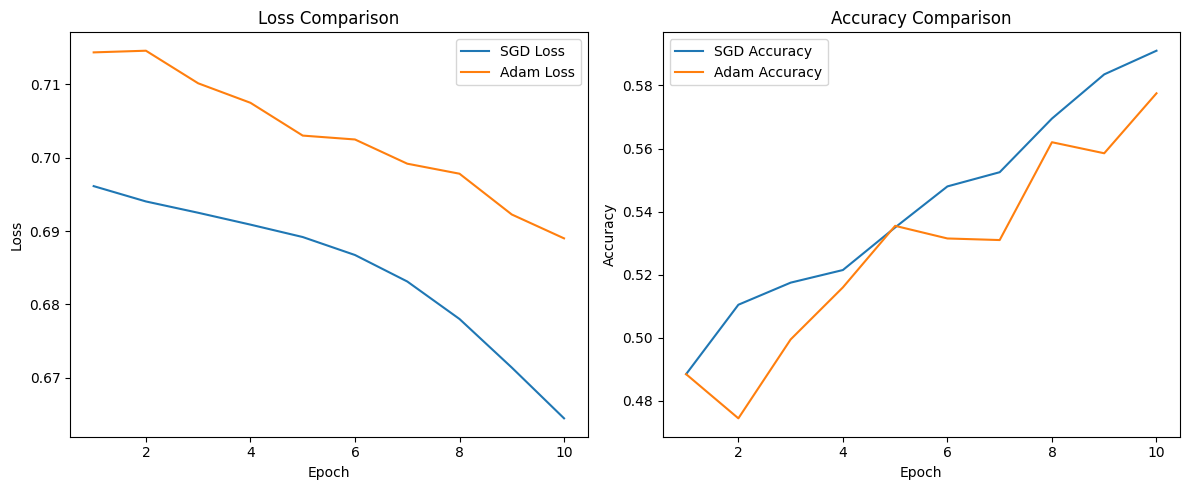

In [ ]:
import matplotlib.pyplot as plt

sgd_epochs, sgd_loss, sgd_acc = zip(*sgd_training_log)
adam_epochs, adam_loss, adam_acc = zip(*adam_training_log)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(sgd_epochs, sgd_loss, label='SGD Loss')
plt.plot(adam_epochs, adam_loss, label='Adam Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(sgd_epochs, sgd_acc, label='SGD Accuracy')
plt.plot(adam_epochs, adam_acc, label='Adam Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
X_train_large = X_seq[:10000]  
y_train_large = y_seq[:10000]

lstm_sgd_50 = LSTMWithSGD(input_size=71, hidden_size=32, output_size=1, learning_rate=0.01)
lstm_adam_50 = LSTMWithAdam(input_size=71, hidden_size=32, output_size=1, learning_rate=0.001)

print("Training LSTM with SGD for 50 epochs...")
sgd_log_50 = lstm_sgd_50.train(X_train_large, y_train_large, epochs=50)

print("\nTraining LSTM with Adam for 50 epochs...")
adam_log_50 = lstm_adam_50.train(X_train_large, y_train_large, epochs=50)

Training LSTM with SGD for 50 epochs...
Epoch 1/50 | Loss: 0.6956 | Accuracy: 49.70%
Epoch 2/50 | Loss: 0.6942 | Accuracy: 50.15%
Epoch 3/50 | Loss: 0.6937 | Accuracy: 50.63%
Epoch 4/50 | Loss: 0.6933 | Accuracy: 51.23%
Epoch 5/50 | Loss: 0.6928 | Accuracy: 51.87%
Epoch 6/50 | Loss: 0.6924 | Accuracy: 52.28%
Epoch 7/50 | Loss: 0.6918 | Accuracy: 52.41%
Epoch 8/50 | Loss: 0.6912 | Accuracy: 52.78%
Epoch 9/50 | Loss: 0.6903 | Accuracy: 53.23%
Epoch 10/50 | Loss: 0.6891 | Accuracy: 53.40%
Epoch 11/50 | Loss: 0.6875 | Accuracy: 54.08%
Epoch 12/50 | Loss: 0.6853 | Accuracy: 54.99%
Epoch 13/50 | Loss: 0.6828 | Accuracy: 55.97%
Epoch 14/50 | Loss: 0.6798 | Accuracy: 56.77%
Epoch 15/50 | Loss: 0.6767 | Accuracy: 57.37%
Epoch 16/50 | Loss: 0.6736 | Accuracy: 58.33%
Epoch 17/50 | Loss: 0.6699 | Accuracy: 58.99%
Epoch 18/50 | Loss: 0.6662 | Accuracy: 59.81%
Epoch 19/50 | Loss: 0.6610 | Accuracy: 60.83%
Epoch 20/50 | Loss: 0.6564 | Accuracy: 61.31%
Epoch 21/50 | Loss: 0.6508 | Accuracy: 61.83%
Epo

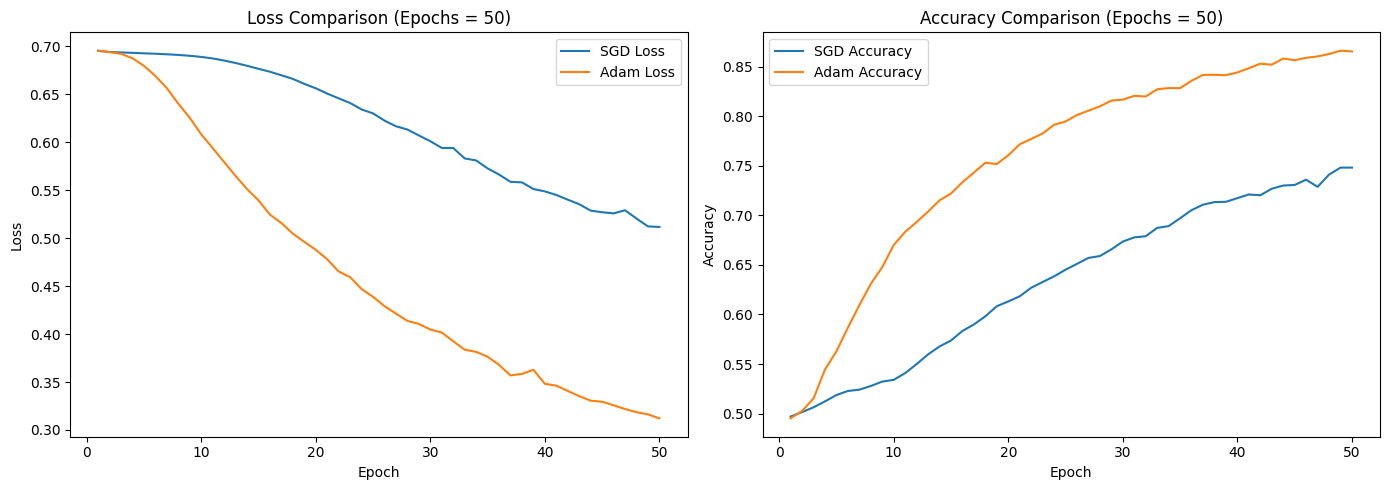

In [ ]:
import matplotlib.pyplot as plt

epochs = [e for e, _, _ in sgd_log_50]
sgd_loss = [l for _, l, _ in sgd_log_50]
sgd_acc = [a for _, _, a in sgd_log_50]

adam_loss = [l for _, l, _ in adam_log_50]
adam_acc = [a for _, _, a in adam_log_50]

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, sgd_loss, label='SGD Loss')
plt.plot(epochs, adam_loss, label='Adam Loss')
plt.title('Loss Comparison (Epochs = 50)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, sgd_acc, label='SGD Accuracy')
plt.plot(epochs, adam_acc, label='Adam Accuracy')
plt.title('Accuracy Comparison (Epochs = 50)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

lstm_sgd_val = LSTMWithSGD(input_size=68, hidden_size=32, output_size=1, learning_rate=0.01)
lstm_adam_val = LSTMWithAdam(input_size=68, hidden_size=32, output_size=1, learning_rate=0.001)

print("Training SGD on training set...")
sgd_log_val = lstm_sgd_val.train(X_train, y_train, epochs=50)

print("\nTraining Adam on training set...")
adam_log_val = lstm_adam_val.train(X_train, y_train, epochs=50)

Training SGD on training set...
Epoch 1/50 | Loss: 0.6945 | Accuracy: 50.11%
Epoch 2/50 | Loss: 0.6942 | Accuracy: 50.33%
Epoch 3/50 | Loss: 0.6941 | Accuracy: 50.48%
Epoch 4/50 | Loss: 0.6940 | Accuracy: 50.74%
Epoch 5/50 | Loss: 0.6938 | Accuracy: 50.91%
Epoch 6/50 | Loss: 0.6936 | Accuracy: 51.44%
Epoch 7/50 | Loss: 0.6934 | Accuracy: 51.54%
Epoch 8/50 | Loss: 0.6931 | Accuracy: 51.73%
Epoch 9/50 | Loss: 0.6927 | Accuracy: 51.92%
Epoch 10/50 | Loss: 0.6923 | Accuracy: 52.17%
Epoch 11/50 | Loss: 0.6918 | Accuracy: 52.66%
Epoch 12/50 | Loss: 0.6914 | Accuracy: 52.85%
Epoch 13/50 | Loss: 0.6909 | Accuracy: 53.01%
Epoch 14/50 | Loss: 0.6903 | Accuracy: 53.44%
Epoch 15/50 | Loss: 0.6896 | Accuracy: 53.62%
Epoch 16/50 | Loss: 0.6889 | Accuracy: 53.89%
Epoch 17/50 | Loss: 0.6881 | Accuracy: 54.11%
Epoch 18/50 | Loss: 0.6873 | Accuracy: 54.50%
Epoch 19/50 | Loss: 0.6864 | Accuracy: 54.91%
Epoch 20/50 | Loss: 0.6853 | Accuracy: 55.25%
Epoch 21/50 | Loss: 0.6843 | Accuracy: 55.69%
Epoch 22/50

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
def predict_binary(model, X):
    preds = []
    for x in X:
        prob, _ = model.forward(x)
        preds.append(1 if prob > 0.5 else 0)
    return preds

y_pred_sgd = predict_binary(lstm_sgd_val, X_val)
y_pred_adam = predict_binary(lstm_adam_val, X_val)

acc_sgd = accuracy_score(y_val, y_pred_sgd)
acc_adam = accuracy_score(y_val, y_pred_adam)

print(f"\nSGD Validation Accuracy:  {acc_sgd:.4f}")
print(f"Adam Validation Accuracy: {acc_adam:.4f}")

print("\nSGD Classification Report:")
print(classification_report(y_val, y_pred_sgd))

print("Adam Classification Report:")
print(classification_report(y_val, y_pred_adam))


SGD Validation Accuracy:  0.4957
Adam Validation Accuracy: 0.5044

SGD Classification Report:
              precision    recall  f1-score   support

         0.0       0.49      0.52      0.50      5177
         1.0       0.50      0.47      0.49      5336

    accuracy                           0.50     10513
   macro avg       0.50      0.50      0.50     10513
weighted avg       0.50      0.50      0.50     10513

Adam Classification Report:
              precision    recall  f1-score   support

         0.0       0.50      0.57      0.53      5177
         1.0       0.51      0.44      0.47      5336

    accuracy                           0.50     10513
   macro avg       0.51      0.51      0.50     10513
weighted avg       0.51      0.50      0.50     10513



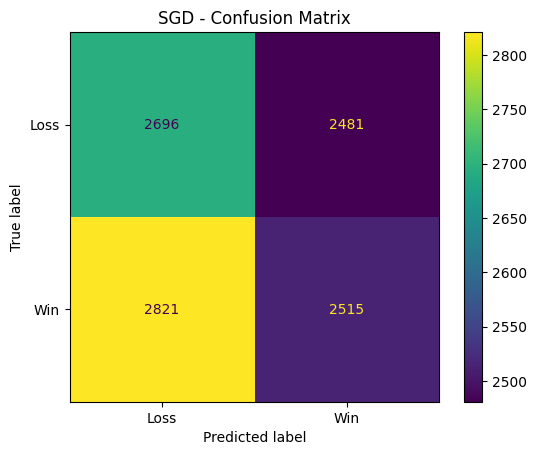

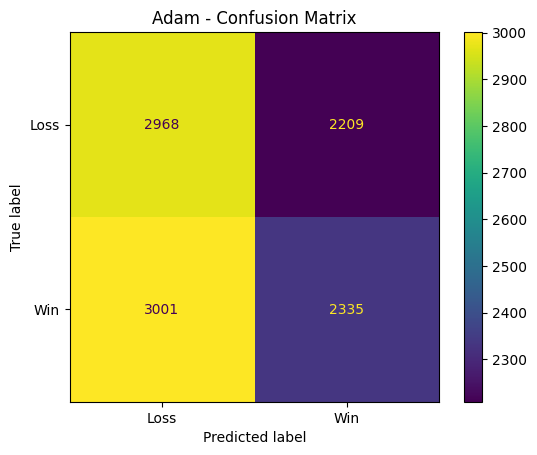

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_sgd, display_labels=["Loss", "Win"])
plt.title("SGD - Confusion Matrix")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_val, y_pred_adam, display_labels=["Loss", "Win"])
plt.title("Adam - Confusion Matrix")
plt.show()

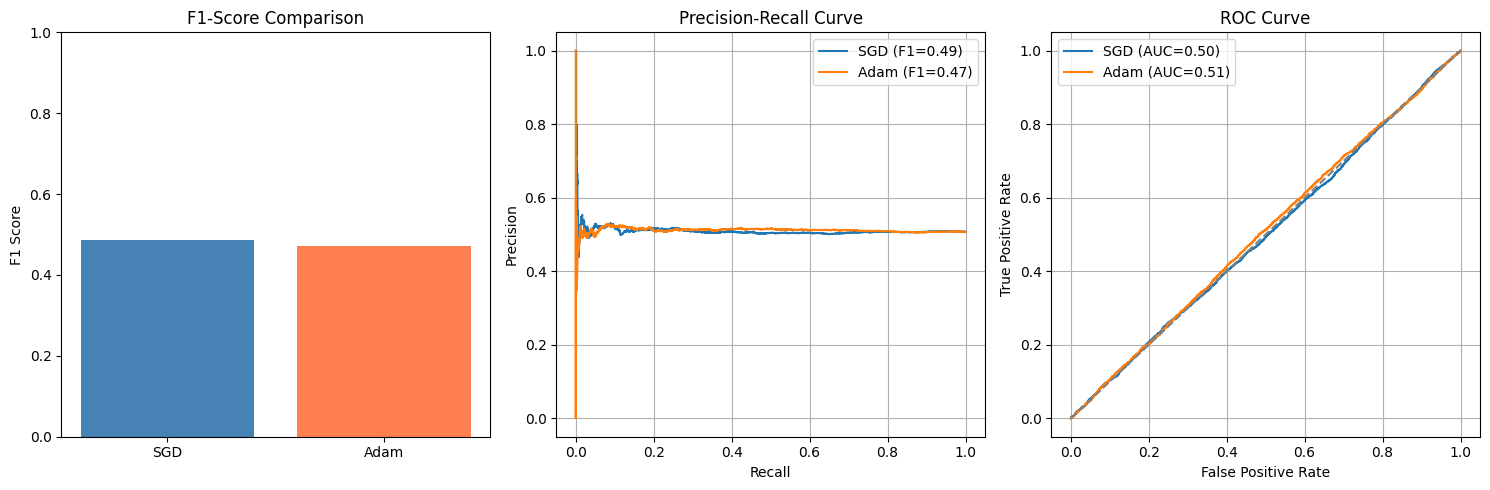

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    f1_score, precision_recall_curve, roc_curve, auc
)

def predict_binary_with_prob(model, X):
    preds = []
    probs = []
    for x in X:
        prob, _ = model.forward(x)
        preds.append(1 if prob > 0.5 else 0)
        probs.append(prob[0][0])  
    return preds, probs

y_pred_sgd, y_prob_sgd = predict_binary_with_prob(lstm_sgd_val, X_val)
y_pred_adam, y_prob_adam = predict_binary_with_prob(lstm_adam_val, X_val)

f1_sgd = f1_score(y_val, y_pred_sgd)
f1_adam = f1_score(y_val, y_pred_adam)

precision_sgd, recall_sgd, _ = precision_recall_curve(y_val, y_prob_sgd)
precision_adam, recall_adam, _ = precision_recall_curve(y_val, y_prob_adam)

fpr_sgd, tpr_sgd, _ = roc_curve(y_val, y_prob_sgd)
fpr_adam, tpr_adam, _ = roc_curve(y_val, y_prob_adam)
auc_sgd = auc(fpr_sgd, tpr_sgd)
auc_adam = auc(fpr_adam, tpr_adam)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.bar(["SGD", "Adam"], [f1_sgd, f1_adam], color=["steelblue", "coral"])
plt.ylim(0, 1)
plt.title("F1-Score Comparison")
plt.ylabel("F1 Score")

plt.subplot(1, 3, 2)
plt.plot(recall_sgd, precision_sgd, label=f'SGD (F1={f1_sgd:.2f})')
plt.plot(recall_adam, precision_adam, label=f'Adam (F1={f1_adam:.2f})')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(fpr_sgd, tpr_sgd, label=f'SGD (AUC={auc_sgd:.2f})')
plt.plot(fpr_adam, tpr_adam, label=f'Adam (AUC={auc_adam:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

### Learning Rate Tuning + Early Stopping

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def early_stopping_train(model, X_train, y_train, X_val, y_val,
                         epochs=50, patience=5, min_delta=0.001):
    best_loss = float('inf')
    patience_counter = 0
    history = []

    for epoch in range(epochs):
        total_loss = 0
        correct = 0

        for i in range(len(X_train)):
            x_seq = X_train[i]
            y_true = y_train[i]
            y_pred, _ = model.forward(x_seq)
            loss = binary_cross_entropy(np.array([y_true]), y_pred)
            total_loss += loss
            if (y_pred > 0.5 and y_true == 1) or (y_pred <= 0.5 and y_true == 0):
                correct += 1
            model.backward(x_seq, y_true, y_pred)

        val_loss = 0
        val_correct = 0
        for i in range(len(X_val)):
            x_seq = X_val[i]
            y_true = y_val[i]
            y_pred, _ = model.forward(x_seq)
            val_loss += binary_cross_entropy(np.array([y_true]), y_pred)
            if (y_pred > 0.5 and y_true == 1) or (y_pred <= 0.5 and y_true == 0):
                val_correct += 1

        avg_train_loss = total_loss / len(X_train)
        avg_val_loss = val_loss / len(X_val)
        train_acc = correct / len(X_train)
        val_acc = val_correct / len(X_val)

        history.append((epoch + 1, avg_train_loss, train_acc, avg_val_loss, val_acc))
        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

        if best_loss - avg_val_loss > min_delta:
            best_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    return history

X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

sgd_lrs = [0.005, 0.001]
adam_lrs = [0.0005, 0.0001]

results = {}

for lr in sgd_lrs:
    print(f"\n--- SGD with LR={lr} ---")
    model = LSTMWithSGD(input_size=68, hidden_size=32, output_size=1, learning_rate=lr)
    history = early_stopping_train(model, X_train, y_train, X_val, y_val)
    results[f"SGD_{lr}"] = history

for lr in adam_lrs:
    print(f"\n--- Adam with LR={lr} ---")
    model = LSTMWithAdam(input_size=68, hidden_size=32, output_size=1, learning_rate=lr)
    history = early_stopping_train(model, X_train, y_train, X_val, y_val)
    results[f"Adam_{lr}"] = history



--- SGD with LR=0.005 ---
Epoch 1 | Train Loss: 0.6940 | Val Loss: 0.6947 | Val Acc: 0.4984
Epoch 2 | Train Loss: 0.6936 | Val Loss: 0.6949 | Val Acc: 0.4959
Epoch 3 | Train Loss: 0.6935 | Val Loss: 0.6951 | Val Acc: 0.4946
Epoch 4 | Train Loss: 0.6934 | Val Loss: 0.6953 | Val Acc: 0.4964
Epoch 5 | Train Loss: 0.6933 | Val Loss: 0.6954 | Val Acc: 0.4980
Epoch 6 | Train Loss: 0.6932 | Val Loss: 0.6956 | Val Acc: 0.4982
Early stopping triggered at epoch 6

--- SGD with LR=0.001 ---
Epoch 1 | Train Loss: 0.6937 | Val Loss: 0.6941 | Val Acc: 0.4961
Epoch 2 | Train Loss: 0.6932 | Val Loss: 0.6940 | Val Acc: 0.4962
Epoch 3 | Train Loss: 0.6930 | Val Loss: 0.6939 | Val Acc: 0.4983
Epoch 4 | Train Loss: 0.6929 | Val Loss: 0.6939 | Val Acc: 0.4998
Epoch 5 | Train Loss: 0.6929 | Val Loss: 0.6939 | Val Acc: 0.5006
Epoch 6 | Train Loss: 0.6928 | Val Loss: 0.6939 | Val Acc: 0.5020
Early stopping triggered at epoch 6

--- Adam with LR=0.0005 ---
Epoch 1 | Train Loss: 0.6940 | Val Loss: 0.6942 | Val

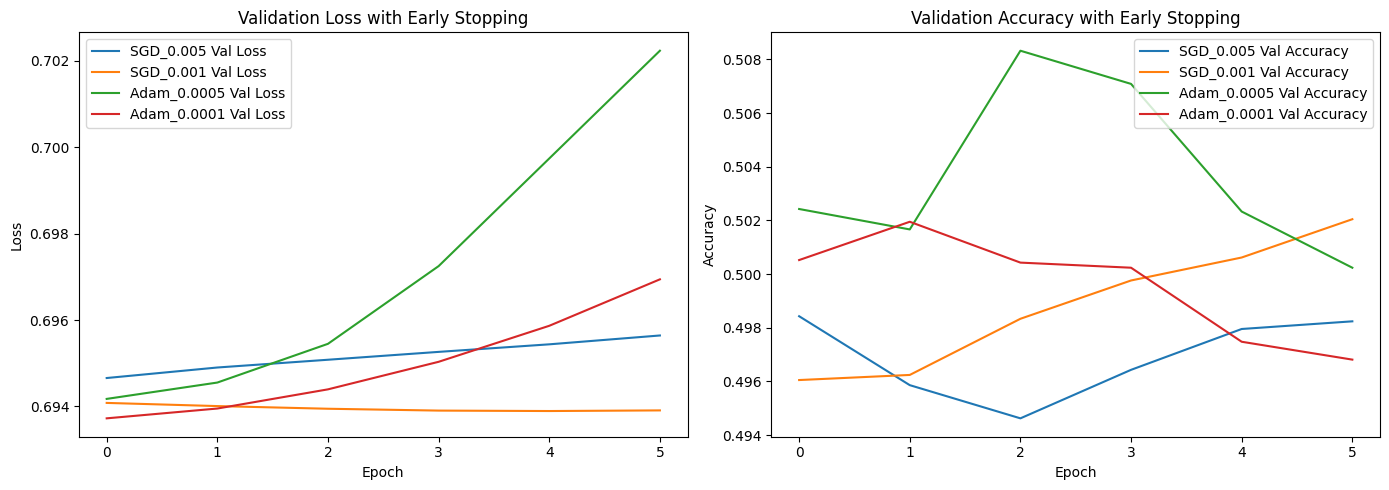

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
for label, hist in results.items():
    val_losses = [entry[3] for entry in hist]
    plt.plot(val_losses, label=f'{label} Val Loss')
plt.title("Validation Loss with Early Stopping")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
for label, hist in results.items():
    val_accs = [entry[4] for entry in hist]
    plt.plot(val_accs, label=f'{label} Val Accuracy')
plt.title("Validation Accuracy with Early Stopping")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()